In [5]:
import pandas as pd
import obspy as obs
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def __smooth(y, npts, win="hanning"):

    from numpy import ones, convolve, hanning, nan

    if win == "hanning":
        win = hanning(npts)
    elif win == "boxcar":
        win = ones(npts)

    y_smooth = convolve(y, win/sum(win), mode='same')

    y_smooth[:npts//2] = nan
    y_smooth[-npts//2:] = nan
    return y_smooth

In [31]:
def __load_fsr_data(tbeg, tend, path_to_data):

    from obspy import UTCDateTime
    from datetime import date
    from pandas import read_csv, concat, DataFrame, date_range, to_datetime

    t1 = date.fromisoformat(str(UTCDateTime(tbeg).date))
    t2 = date.fromisoformat(str((UTCDateTime(tend)).date))

    df = DataFrame()
    for dat in date_range(t1, t2):
        print(str(dat)[:10])
        file = f"romy_fsr_{str(dat)[:10].replace('-','')}.csv"
        try:
            df0 = read_csv(path_to_data+file)
            df = concat([df, df0])
        except:
            print(f"error for {file}")

    # remove NaN from time column
    # df.dropna(subset=['time'], inplace=True)

    # reset the index column
    df.reset_index(inplace=True, drop=True)

    # add column for relative time in seconds
    df['time_sec'] = [UTCDateTime(str(_t)) - UTCDateTime(df.datetime.iloc[0]) for _t in df.datetime]

    return df

In [32]:
!ls /home/andbro/kilauea-data/romy_fsr/data/

romy_fsr_20240821.csv	      romy_fsr_20240823.csv
romy_fsr_20240821T140958.csv  romy_fsr_20240824.csv
romy_fsr_20240822.csv	      romy_fsr_20240825.csv
romy_fsr_20240822T123702.csv


In [33]:
config = {}

# path to data
# config['path'] = "./data/"
config['path'] = "/home/andbro/kilauea-data/romy_fsr/data/"

# specify time period
config['tbeg'] = "2024-08-22"
config['tend'] = "2024-08-24"


In [35]:
df0 = __load_fsr_data(config['tbeg'], config['tend'], config['path'])

2024-08-22
                         datetime          x_hz      y_dbm
0      2024-08-22 00:00:00.426065  1.072967e+08 -67.082436
1      2024-08-22 00:00:01.430055  1.072967e+08 -69.578888
2      2024-08-22 00:00:02.435924  1.072967e+08 -70.409180
3      2024-08-22 00:00:03.438788  1.072967e+08 -71.415497
4      2024-08-22 00:00:04.442842  1.072967e+08 -68.877838
...                           ...           ...        ...
82985  2024-08-22 23:59:55.742072  1.072966e+08 -78.795731
82986  2024-08-22 23:59:56.745990  1.072966e+08 -80.340973
82987  2024-08-22 23:59:57.749957  1.072966e+08 -80.474014
82988  2024-08-22 23:59:58.753855  1.072966e+08 -80.971016
82989  2024-08-22 23:59:59.757919  1.072966e+08 -79.432312

[82990 rows x 3 columns]
2024-08-23
                         datetime          x_hz      y_dbm
0      2024-08-23 00:00:00.761952  1.072966e+08 -76.013435
1      2024-08-23 00:00:01.765896  1.072966e+08 -75.845665
2      2024-08-23 00:00:02.768741  1.072966e+08 -72.673897
3      2

In [40]:
df0

,datetime,x_hz,y_dbm,time_sec
0,2024-08-22 00:00:00.426065,1.072967e+08,-67.082436,0.000000
1,2024-08-22 00:00:01.430055,1.072967e+08,-69.578888,1.003990
2,2024-08-22 00:00:02.435924,1.072967e+08,-70.409180,2.009859
3,2024-08-22 00:00:03.438788,1.072967e+08,-71.415497,3.012723
4,2024-08-22 00:00:04.442842,1.072967e+08,-68.877838,4.016777
...,...,...,...,...
255094,2024-08-24 23:59:55.554605,1.072965e+08,-77.803307,259195.128540
255095,2024-08-24 23:59:56.558586,1.072965e+08,-76.052963,259196.132521
255096,2024-08-24 23:59:57.562515,1.072965e+08,-73.371117,259197.136450
255097,2024-08-24 23:59:58.566429,1.072965e+08,-72.710556,259198.140364


In [41]:
# free spectral range of ROMY
fsr = 8.94e6

# nth FSR peak
n = 12

# side length of cavity
L = 11.2

# perimeter of cavity
P = 3*L

In [42]:

# starttime = obs.UTCDateTime(df0.datetime.iloc[0])

# df0['time_sec'] = np.array([obs.UTCDateTime(_dt) - starttime for _dt in df0.datetime])

In [43]:
df = df0.copy()

fmode = df.x_hz.iloc[0]*1e-6

dbm_threshold = 100

df['x_mod'] = np.where(abs(df.y_dbm) < dbm_threshold, df.x_hz, np.nan)

df['x_mod_rel'] = df.x_mod - np.nanmean(df.x_mod[:100])

df['y_mod'] = np.where(abs(df.y_dbm) < dbm_threshold, df.y_dbm, np.nan)

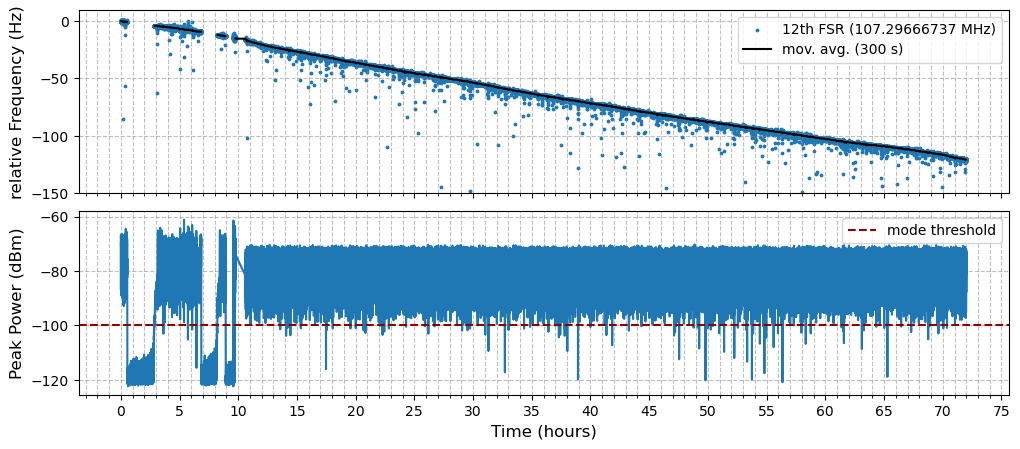

In [49]:
def __makeplot(df):

    import matplotlib.pyplot as plt
    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

    Nrow, Ncol = 2, 1

    xscale = 1

    tscale, tunit = 1/3600, "hours"

    ymin, ymax = -150, 10

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    tsec = 300
    ax[0].scatter(df['time_sec']*tscale, df.x_mod_rel, s=3, color="tab:blue", label=f"{n}th FSR ({fmode} MHz)")
    ax[0].plot(df['time_sec']*tscale, __smooth(df.x_mod_rel, tsec), "k", label=f"mov. avg. ({tsec} s)", zorder=5)
    ax[0].ticklabel_format(useOffset=False)

    ax[0].set_ylim(ymin, ymax)

    ax[1].plot(df['time_sec']*tscale, df.y_dbm)
    ax[1].axhline(-dbm_threshold, color="darkred", ls="--", label="mode threshold")

    for i in range(Nrow):
        ax[i].grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)
        ax[i].legend(loc=1, fontsize=font-2)
        ax[i].xaxis.set_major_locator(MultipleLocator(5))
        ax[i].xaxis.set_minor_locator(MultipleLocator(1))

    ax[0].set_ylabel("relative Frequency (Hz)", fontsize=font)
    ax[1].set_ylabel("Peak Power (dBm)", fontsize=font)
    ax[1].set_xlabel(f"Time ({tunit})", fontsize=font)

    plt.show();
    return fig

fig = __makeplot(df);


In [45]:
# df['disp_um'] = 1e6 * P * df.x_mod_rel / (n * fsr)

df['disp_um'] = (3e8 / (df.x_mod / n))

df['disp_um_rel'] = (3e8 / (df.x_mod / n)) - df.disp_um.iloc[0]


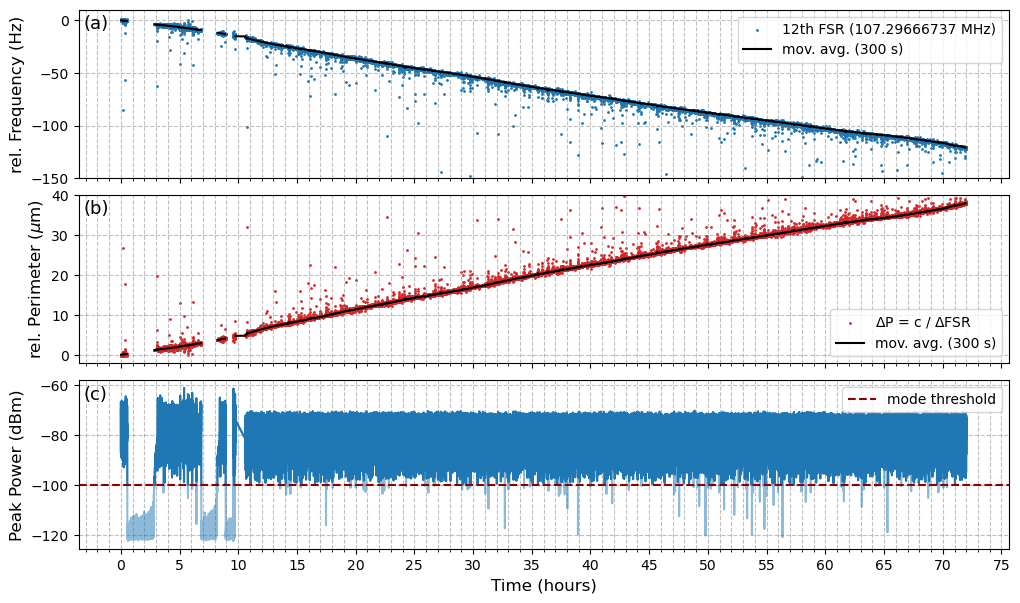

In [53]:
def __makeplot(df):

    import matplotlib.pyplot as plt
    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

    Nrow, Ncol = 3, 1

    xscale = 1

    tscale, tunit = 1/3600, "hours"

    dscale, dunit = 1e6, "$\mu$m"

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 7), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    tsec = 300
    ax[0].scatter(df['time_sec']*tscale, df.x_mod_rel, s=1, color="tab:blue", label=f"{n}th FSR ({fmode} MHz)")
    ax[0].plot(df['time_sec']*tscale, __smooth(df.x_mod_rel, tsec), "k", label=f"mov. avg. ({tsec} s)", zorder=5)
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylim(-150, 10)

    ax[1].scatter(df['time_sec']*tscale, df.disp_um_rel*dscale, s=1, color="tab:red", label=f"$\Delta$P = c / $\Delta$FSR")
    ax[1].plot(df['time_sec']*tscale, __smooth(df.disp_um_rel*dscale, tsec), "k", label=f"mov. avg. ({tsec} s)", zorder=5)
    ax[1].ticklabel_format(useOffset=False)
    ax[1].set_ylim(-2, 40)

    ax[2].plot(df['time_sec']*tscale, df.y_dbm, alpha=0.5)
    ax[2].plot(df['time_sec']*tscale, df.y_mod, color="tab:blue")
    ax[2].axhline(-dbm_threshold, color="darkred", ls="--", label="mode threshold")

    for i in range(Nrow):
        ax[i].grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)
        ax[i].legend(loc=1, fontsize=font-2)
        ax[i].xaxis.set_major_locator(MultipleLocator(5))
        ax[i].xaxis.set_minor_locator(MultipleLocator(1))

    ax[1].legend(loc=4, fontsize=font-2)

    ax[0].set_ylabel(f"rel. Frequency (Hz)", fontsize=font)
    ax[1].set_ylabel(f"rel. Perimeter ({dunit})", fontsize=font)
    ax[2].set_ylabel(f"Peak Power (dBm)", fontsize=font)
    ax[2].set_xlabel(f"Time ({tunit})", fontsize=font)

    for _k, ll in enumerate(['(a)','(b)','(c)']):
        ax[_k].text(0.005, 0.97, ll, ha="left", va="top", transform=ax[_k].transAxes, fontsize=font+1)

    plt.show();
    return fig

fig = __makeplot(df);
